# Project 4 - Advanced lane finding
This document contains code for Udacity Self-driving car nanodegree. In this project the goal is to:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply the distortion correction to the raw image.  
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view"). 
* Detect lane pixels and fit to find lane boundary.
* Determine curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from IPython import display
%matplotlib inline

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

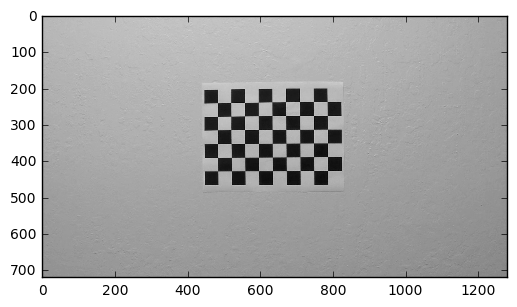

calibration6.jpg ny = 9 nx = 6


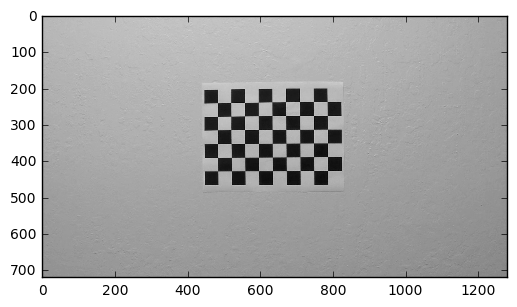

In [2]:
#Getting the calibration image filanames
cal_pic = os.listdir("camera_cal/")

#Going through all the images
objpoints = []
imgpoints = []
for pic in cal_pic:
    img = mpimg.imread('camera_cal/'+pic)
    #The findChessboardCorners does not find all patterns with same
    #nx, ny grid. So some combinations are tested. This will take some time.
    flag=1
    for i in range(3):
        for j in range(4):
            nx = 6-i
            ny = 9-j
            if flag == 1:
                objp = np.zeros((nx*ny,3), np.float32)
                objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
                gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
                if ret == True:
                    #If corners are found, they are added to the point lists
                    imgpoints.append(corners)
                    objpoints.append(objp)
                    plt.imshow(gray,cmap='gray')
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                    print(pic,'ny =',ny,'nx =',nx)
                    flag = 0

In [3]:
#Calculating the camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print('Camera calibration done.')

Camera calibration done.


### Apply the distortion correction to the raw image.  

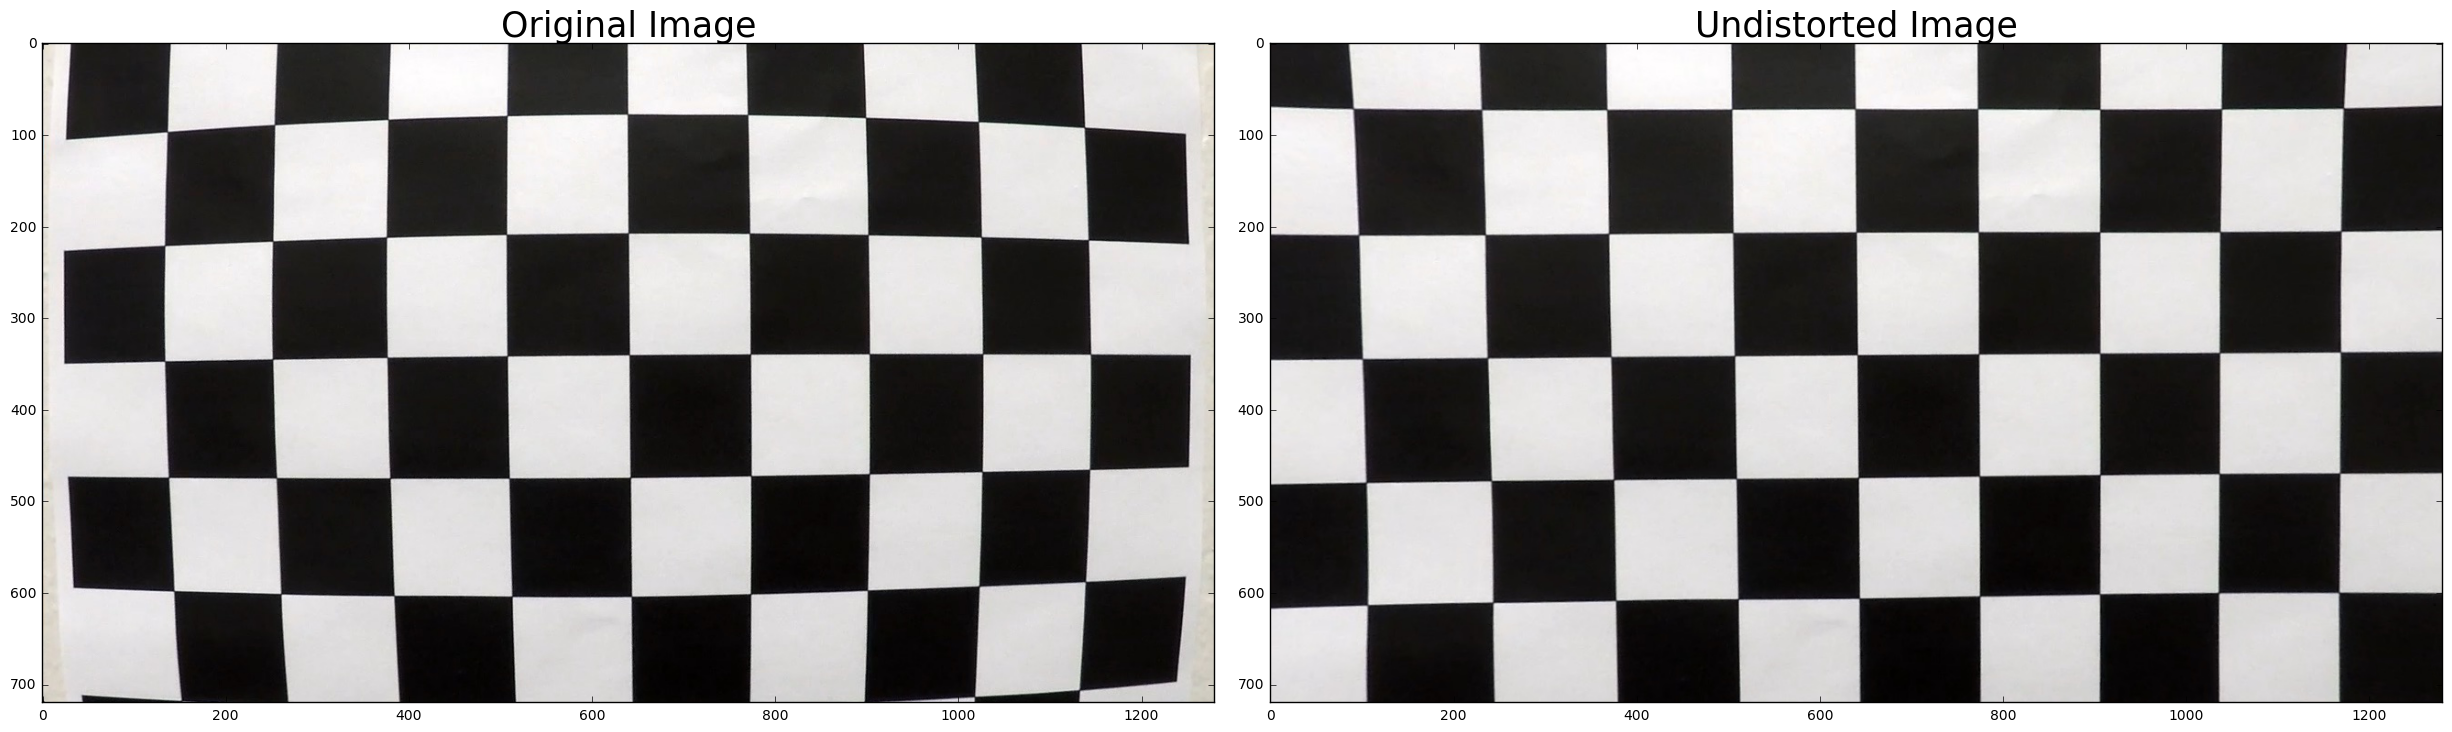

In [4]:
#Testing the calibration
img = mpimg.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

#Plotting distorted and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/calibration.png')

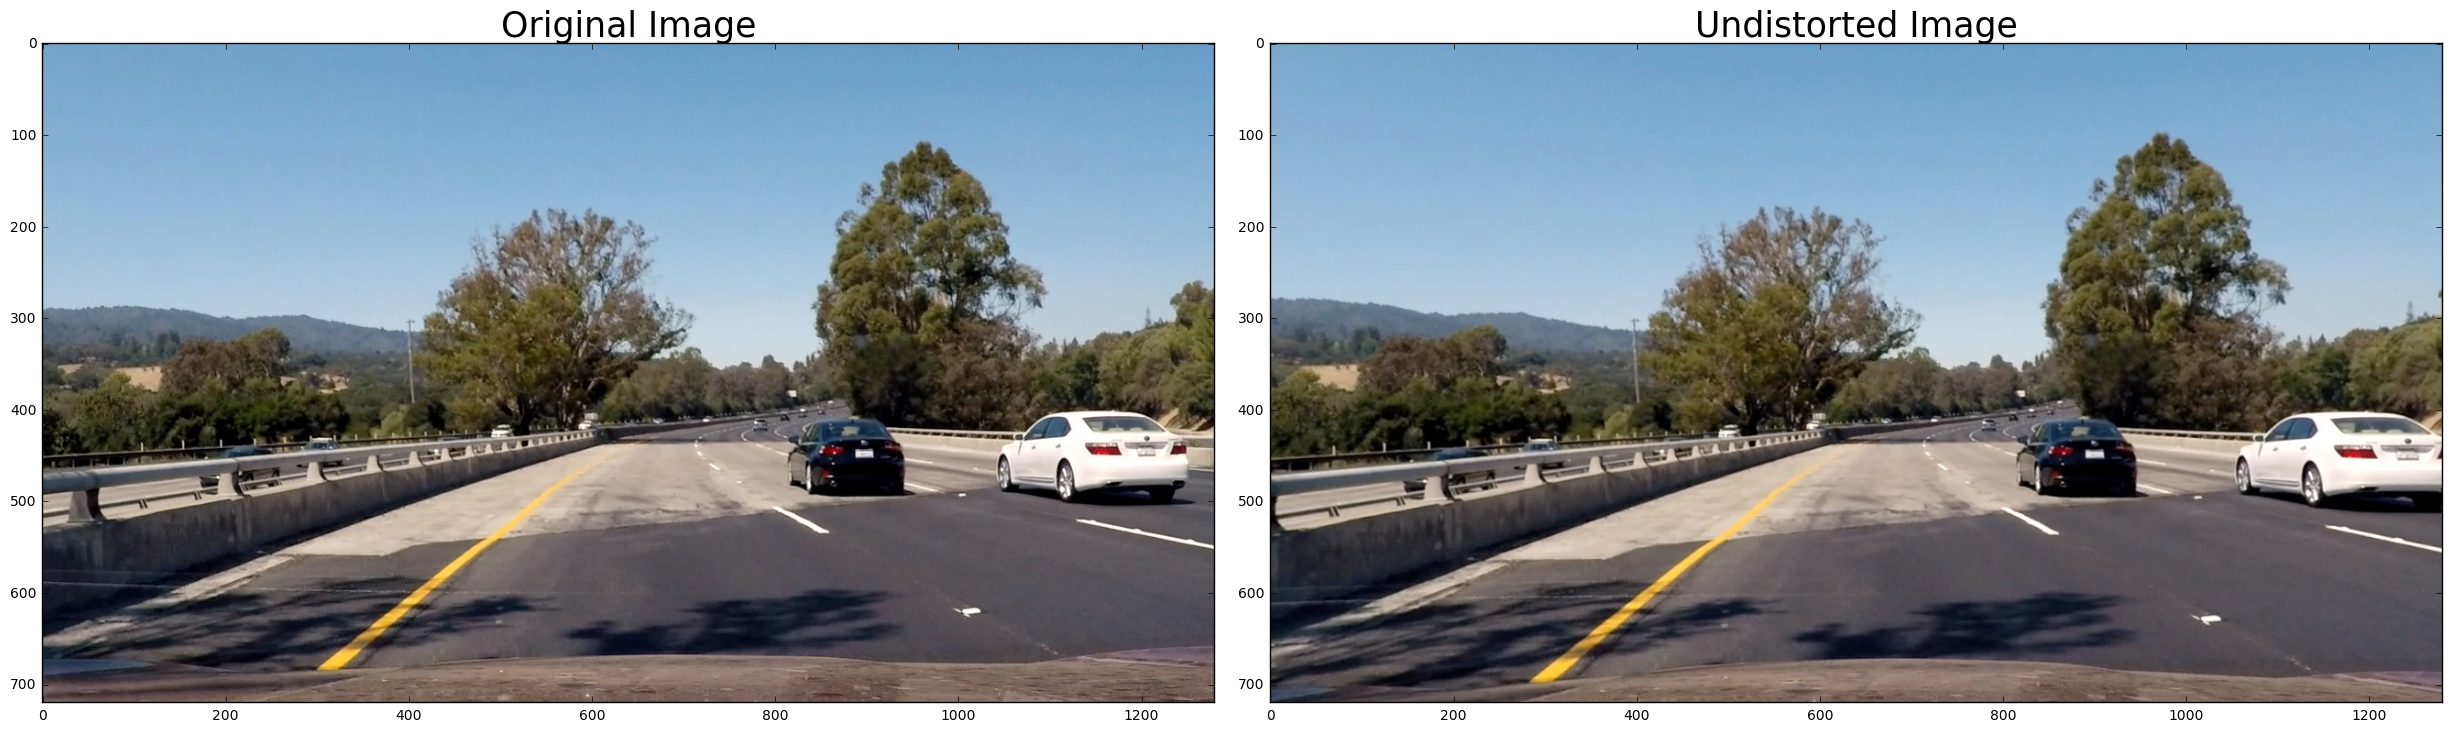

In [5]:
#Testing the calibration on a real image
img = mpimg.imread('test_images/test4.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

#Plotting distorted and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/test_calibration.png')

### Use color transforms, gradients, etc., to create a thresholded binary image.

In [6]:
def colthre(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #img = np.copy(img)
    img = cv2.undistort(np.copy(img), mtx, dist, None, mtx)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary.astype('uint8')  

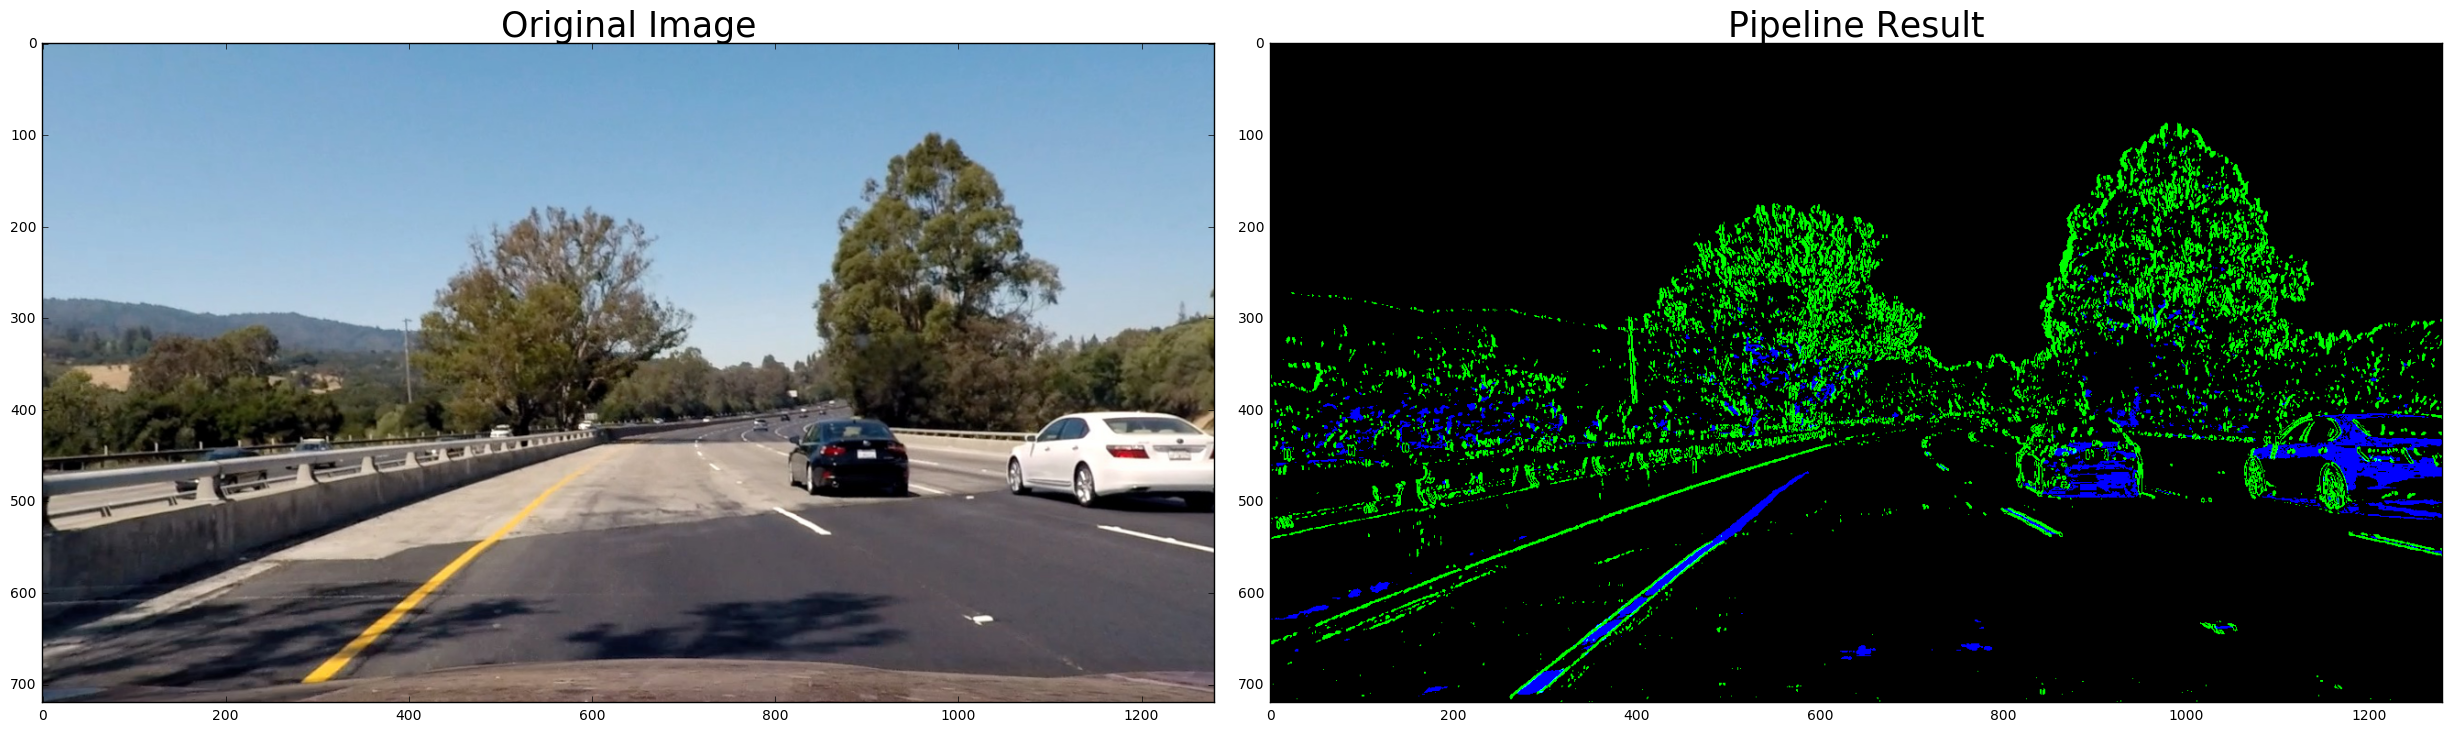

In [7]:
img = mpimg.imread('test_images/test5.jpg')
img = dst
result = colthre(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(result*255)
ax2.set_title('Pipeline Result', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/threshold.png')

### Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
#Defining perspective transform
def perspec(img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([[50,700],[1250,700],[760,470],[490,470]])
    dst = np.float32([[0,700],[1200,700],[1200, 0],[0,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
#Defining perspective transform back to original
def perspec_back(img):
    img_size = (img.shape[1],img.shape[0])
    dst = np.float32([[50,700],[1250,700],[760,470],[490,470]])
    src = np.float32([[0,700],[1200,700],[1200, 0],[0,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

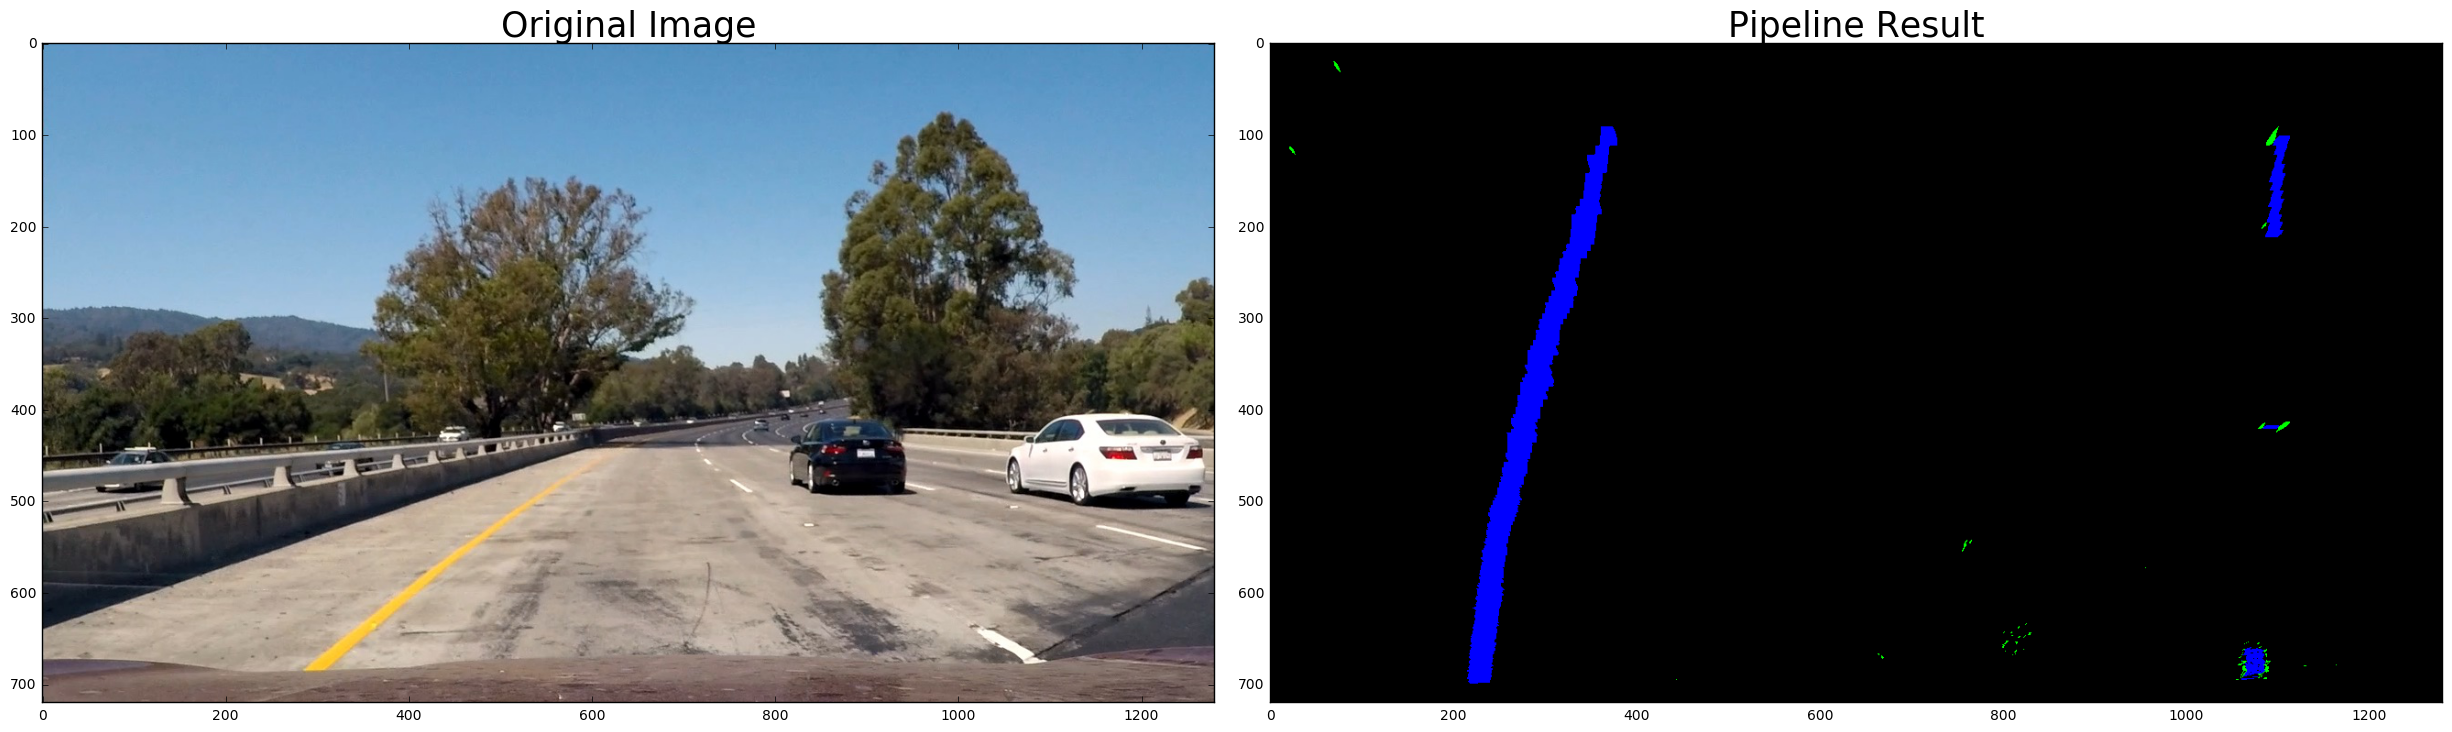

In [9]:
img = mpimg.imread('test_images/test1.jpg')

result = colthre(img, s_thresh=(180, 255), sx_thresh=(50, 100))
result = perspec(result)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(result*255)
ax2.set_title('Pipeline Result', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/threshold_perspective.png')

### Detect lane pixels and fit to find lane boundary.

/home/jouni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jouni/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


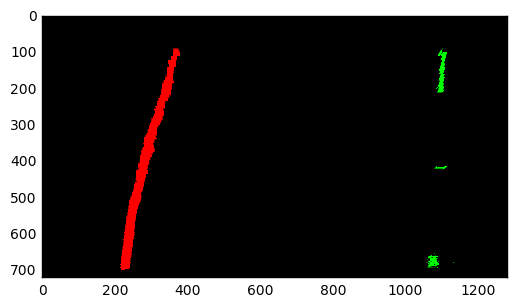

In [10]:
#Deque creates a list with defined history
from collections import deque

#These are created to keep records from previous images and lanes
history = 15
left_lanes = deque(maxlen=history)
right_lanes= deque(maxlen=history)
left_lanes_m = deque(maxlen=history)
right_lanes_m= deque(maxlen=history)

def mean_history(data):
    #This returns the mean of fit parameters
    a, b, c = 0, 0 ,0
    n=0
    for i in list(data):
        a += i[0]
        b += i[1]
        c += i[2]
        n += 1
    return np.array([a/n, b/n, c/n])

def lane_lines(img, left_lanes, right_lanes):
    if len(left_lanes) < history:
        result = img[:]
        lanes = np.zeros_like(result)
        #Summing the two binary layers and taking a histogram of those pixels
        histogram = np.sum(np.sum(img,axis=2), axis=0)
        #Assuming peak values to be at least higher than 1/10
        histogram = ((histogram>max(histogram)/10) == 1)
        #Detecting two lanes
        x_left_lane = np.arange(0,len(histogram)/2)
        x_right_lane = np.arange(len(histogram)/2,len(histogram))
        #Assigning peak pixels to lanes
        x_left_lane = x_left_lane[histogram[0:len(histogram)/2]]
        x_right_lane= x_right_lane[histogram[len(histogram)/2:len(histogram)]]
        #Estimation of lane width (maximum 200)
        if len(x_left_lane) == 0 or len(x_right_lane)==0:
            w_left = 200
            w_right= 200
            x_left_lane = 200
            x_right_lane= 1100
        else:
            w_left = int((max(x_left_lane) - min(x_left_lane)))
            w_right = int((max(x_right_lane) - min(x_right_lane)))

        if w_left > 200:
            w_left = 200

        if w_right > 200:
            w_right = 200
        #Taking the mean as the assumed center of the lane line
        x_left_lane = int(np.mean(x_left_lane))
        x_right_lane= int(np.mean(x_right_lane))

        img = np.sum(result,axis=2)

        lanes[:,int(x_left_lane-w_left):int(x_left_lane+w_left),0] = \
          img[:,int(x_left_lane-w_left):int(x_left_lane+w_left)]
        lanes[:,int(x_right_lane-w_right):int(x_right_lane+w_right),1] = \
          img[:,int(x_right_lane-w_right):int(x_right_lane+w_right)]
    else:
        result = img[:]
        img = np.sum(result,axis=2)
        lanes = np.zeros_like(result)
        #Masking the image using existing lane estimations
        al = mean_history(left_lanes)[0]
        bl = mean_history(left_lanes)[1]
        cl = mean_history(left_lanes)[2]

        ar = mean_history(right_lanes)[0]
        br = mean_history(right_lanes)[1]
        cr = mean_history(right_lanes)[2]
        #Selecting the estimated locations
        for i in range(img.shape[0]):
            #Left lane
            lane_min = int(al*i**2 + bl*i + cl) - 50
            lane_max = lane_min + 100
            lanes[i,lane_min:lane_max,0] = img[i,lane_min:lane_max]
            #Right lane
            lane_min = int(ar*i**2 + br*i + cr) - 50
            lane_max = lane_min + 100
            lanes[i,lane_min:lane_max,1] = img[i,lane_min:lane_max]

    return lanes

lanes = lane_lines(result, left_lanes, right_lanes)
plt.imshow(lanes*255)
plt.savefig('output_images/lane_separation.png')

Mean curvature is 1865.78247334 meters.
Lane width is 3.31
Car is -0.06 meters off lane center


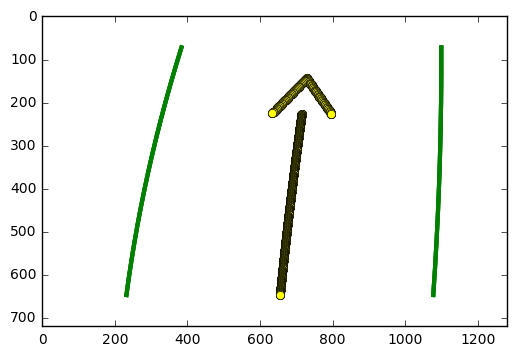

In [11]:
 #Defining a function to calculate a curvature from image channel
def lane_curvature(lanes, plot=0):
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 4.7/1200 # meteres per pixel in x dimension
    
    #Creating a image array with coordinates
    x_img = np.array([np.arange(lanes.shape[1])])
    x_img = np.repeat(x_img, lanes.shape[0] , axis=0)

    y_img = np.array([np.arange(lanes.shape[0])]).T
    y_img = np.repeat(y_img, lanes.shape[1] , axis=1)
    
    #Transforming the image coordinates to vectors
    x_left_lane = x_img[lanes[:,:,0]==1]
    y_left_lane = y_img[lanes[:,:,0]==1]

    x_right_lane= x_img[lanes[:,:,1]==1]
    y_right_lane= y_img[lanes[:,:,1]==1]
    
    #Calculating the left lane
    if len(y_left_lane)==0:
        #Using an older fit
        left_fit = mean_history(left_lanes)
        left_fit_cr = mean_history(left_lanes_m)
        #Removing one from the history
        left_lanes.pop()
        left_lanes_m.pop() 
    else:
        #Fitting vectors to 2nd order polynom
        left_fit = np.polyfit(y_left_lane, x_left_lane, 2)
        left_fit_cr = np.polyfit(y_left_lane*ym_per_pix, x_left_lane*xm_per_pix, 2)
    #Appending to history
    left_lanes.append(left_fit)
    left_lanes_m.append(left_fit_cr)
    #Calculating the mean lane
    left_fit = mean_history(left_lanes)
    left_fit_cr = mean_history(left_lanes_m)
    #Creating lane for plotting
    y_left_lane = np.arange(int(0.8*lanes.shape[0]))+0.1*lanes.shape[0]
    left_fitx = left_fit[0]*y_left_lane**2 + left_fit[1]*y_left_lane + left_fit[2]
    
    #Calculating the right lane
    if len(y_right_lane)==0:
        #Using an older fit
        right_fit = mean_history(right_lanes)
        right_fit_cr = mean_history(right_lanes_m)
        #Removing one from the history
        right_lanes.pop()
        right_lanes_m.pop()
    else:
        #Fitting vectors to 2nd order polynom
        right_fit = np.polyfit(y_right_lane, x_right_lane, 2)    
        right_fit_cr = np.polyfit(y_right_lane*ym_per_pix, x_right_lane*xm_per_pix, 2)
    #Appending to history
    right_lanes.append(right_fit)
    right_lanes_m.append(right_fit_cr)
    #Calculating the mean lane
    right_fit = mean_history(right_lanes)
    right_fit_cr = mean_history(right_lanes_m)
    #Creating lane for plotting
    y_right_lane = np.arange(int(0.8*lanes.shape[0]))+0.1*lanes.shape[0]
    right_fitx = right_fit[0]*y_right_lane**2 + right_fit[1]*y_right_lane + right_fit[2]
    
    #Curvature in meters
    y_eval = np.max(y_left_lane)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    y_eval = np.max(y_right_lane)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
        
    #Calculating the lane locations
    left0 = left_fitx[np.argmax(y_left_lane)]
    right0 = right_fitx[np.argmax(y_right_lane)]
    #This assumes that the image center is the car center
    off_center = lanes.shape[1]/2 - (left0+right0)/2
    
    left0 = left0*xm_per_pix
    right0 = right0*xm_per_pix
    off_center = off_center*xm_per_pix
    
    #Creating the center for plotting
    y_center = np.arange(int(0.7*lanes.shape[0]))+0.2*lanes.shape[0]
    x_center = ((left_fit[0]+right_fit[0])/2)*y_center**2 + \
               ((left_fit[1]+right_fit[1])/2)*y_center + \
               ((left_fit[2]+right_fit[2])/2)
    
    #Making an arrow end
    i0 = 0
    for i in y_center:
        if i < max(y_center)*0.35:
            if i0 % 2 != 0:
                x_center[i0] = x_center[i0] - i0
            else:
                x_center[i0] = x_center[i0] + i0
        i0 += 1
    
    left = np.concatenate(([left_fitx], [y_left_lane]), axis=0)
    right = np.concatenate(([right_fitx], [y_right_lane]), axis=0)
    center = np.concatenate(([x_center],[y_center]), axis=0)
    #Plotting if requested
    if plot==1:
        plt.plot(x_center, y_center, 'o', color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, y_left_lane, color='green', linewidth=3)
        plt.plot(right_fitx, y_right_lane, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images

    return left_curverad, right_curverad, left0, right0, left, right, center, off_center
 
data = lane_curvature(lanes, plot=1)
data = lane_curvature(lanes, plot=1)
data = lane_curvature(lanes, plot=1)
print('Mean curvature is',np.mean(data[0:2]), 'meters.')    
print('Lane width is {0:.2f}'.format(data[3]-data[2]))
print('Car is {0:.2f}'.format(data[7]), 'meters off lane center')
plt.savefig('output_images/detected_lanes.png')

## Warp the detected lane boundaries back onto the original image.


In [12]:
#Plotting function to draw the lanes on image and return the perspective back
def plot_lanes(img, data):
    mask = np.zeros_like(img)
    color=[55, 0, 255]
    thickness=60
    #Drawing the left lane
    for i in range(data[4].shape[1]-1):
        x1 = data[4][0][i].astype('int')
        x2 = data[4][0][i+1].astype('int')
        y1 = data[4][1][i].astype('int')
        y2 = data[4][1][i+1].astype('int')
        cv2.line(mask, (x1, y1), (x2, y2), color, thickness)
    #Drawing the right lane
    for i in range(data[5].shape[1]-1):
        x1 = data[5][0][i].astype('int')
        x2 = data[5][0][i+1].astype('int')
        y1 = data[5][1][i].astype('int')
        y2 = data[5][1][i+1].astype('int')
        cv2.line(mask, (x1, y1), (x2, y2), color, thickness)
    #Drawing the direction arrow
    color=[255, 255, 0]
    for i in range(data[6].shape[1]-1):
        x1 = data[6][0][i].astype('int')
        x2 = data[6][0][i+1].astype('int')
        y1 = data[6][1][i].astype('int')
        y2 = data[6][1][i+1].astype('int')
        cv2.line(mask, (x1, y1), (x2, y2), color, thickness)

    #Returning the perspective back
    mask = perspec_back(mask)
    
    #Adding the lines to the image
    img = cv2.addWeighted(img, 0.9, mask, 1.0, 0.0)
    
    return img
img = plot_lanes(img, data)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

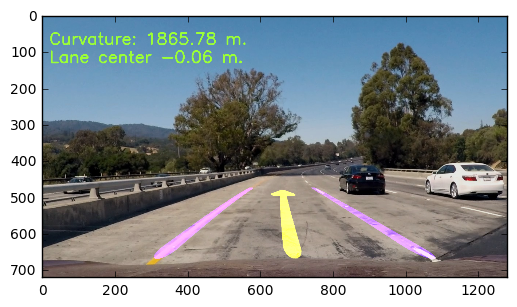

In [13]:
#Write data on image
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img,'Curvature: {0:.2f}'.format(np.mean(data[0:2]))+' m.',(20,80), font, 1.5,(155,255,55),4)
cv2.putText(img,'Lane center {0:.2f}'.format(data[7])+' m.',(20,130), font, 1.5,(155,255,55),4)

plt.imshow(img)
plt.savefig('output_images/final_image.png')

## Output to video of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    img = image[:]
    #Undistorting the image based on camera calibration
    img = cv2.undistort(np.copy(img), mtx, dist, None, mtx)
    #Detecting lane features with thresholding
    img = colthre(img, s_thresh=(180, 255), sx_thresh=(50, 100))
    #Applying perstective transform
    result = perspec(img)
    #Separating lanes from image
    lanes = lane_lines(result, left_lanes, right_lanes)
    #Calculating lane parameters
    data = lane_curvature(lanes)
    #Plotting detected lanes on image
    image = plot_lanes(image, data)
    #Writing data on image
    cv2.putText(image,'Curvature: {0:.2f}'.format(np.mean(data[0:2]))+' m.',(20,80), font, 1.5,(155,255,55),4)
    cv2.putText(image,'Lane center {0:.2f}'.format(data[7])+' m.',(20,130), font, 1.5,(155,255,55),4)
    return image

In [16]:
white_output = 'my_own.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video my_own.mp4
[MoviePy] Writing video my_own.mp4


100%|█████████▉| 1260/1261 [04:01<00:00,  5.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_own.mp4 

CPU times: user 14min 28s, sys: 50 s, total: 15min 18s
Wall time: 4min 1s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [18]:
history = 10
left_lanes = deque(maxlen=history)
right_lanes= deque(maxlen=history)
left_lanes_m = deque(maxlen=history)
right_lanes_m= deque(maxlen=history)

chal_output = 'my_own_chal.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
chal_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time chal_clip.write_videofile(chal_output , audio=False)

[MoviePy] >>>> Building video my_own_chal.mp4
[MoviePy] Writing video my_own_chal.mp4


100%|██████████| 485/485 [01:32<00:00,  5.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_own_chal.mp4 

CPU times: user 5min 32s, sys: 19.2 s, total: 5min 51s
Wall time: 1min 32s


It is quite clear that the algorithm fails on the challenge video. This however is very helpful to understand the required improvements. The video shows the software will fail if there is:
* direct sun light, too much light
* a lot of contrast difference
* differences in road surface can be confused to a lane
* quick turns on the road
* detected lanes can merge

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chal_output))